# Read Features

In [26]:
from read_features import *
from scores import *
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from gph.python import ripser_parallel
from sklearn import set_config
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from time import time

In [27]:
# textual data args
train_set_name, valid_set_name, test_set_name = ("in_domain_train", "in_domain_dev","out_of_domain_dev")
data_dir = "./data/";
file_type = ".csv" 
# features args
model_name = "bert-base-cased_finetuned"
heads="all";
layers=12
MAX_LEN=64
topological_thr=6
topological_features="s_e_v_c_b0b1"
feature_dir = "./features/bert-base-cased_finetuned/"

In [28]:
kwargs = dict(((k, eval(k)) for k in ("feature_dir", "model_name", "heads", "layers", "MAX_LEN", "topological_thr",  "topological_features" )))
X_train, X_valid, X_test = list(map(lambda x_: load_data(x_, **kwargs), [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

Loading out_of_domain_dev features...: 100%|██████████| 432/432 [00:01<00:00, 255.77it/s]


In [29]:
def read_labels(set_name, data_dir = "./data", file_type = ".csv"):
    header = 'infer'
    names = None
    delimeter = ","
    if "tsv" in file_type:
        header = None
        names = ["Source", "label", "code", "sentence"]
        delimeter = "\t"
    df = pd.read_csv(os.path.join(data_dir, set_name+file_type), header=header, names=names, delimiter=delimeter)
    return df["sentence"], df["label"].values

In [30]:
data_args = dict(((k, eval(k)) for k in ("data_dir", "file_type")))
(sents_train, y_train), (sents_valid, y_valid), (sents_test, y_test) = list(map(lambda x_: read_labels(x_, **data_args), 
                                                [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

# Compute H0_S features

In [31]:
def compute_h0_s(data_in):
    X = np.zeros((len(data_in), 144))

    for num in tqdm.tqdm(range(len(data_in))):
        inputs = tokenizer(data_in[num], max_length=MAX_LEN, truncation=True, return_tensors="pt").to(device)
        n_len = inputs['input_ids'].shape[1]

        tmp = model(**inputs)
        goods_list = tmp[1]
        goods_list = torch.stack(goods_list, dim=0)[:12, 0, :12, :, :]

        for i in range(12):
            for j in range(12):
                d_good_tmp = 1.0 - torch.max(goods_list[i][j], torch.transpose(goods_list[i][j], 0, 1))

                d_good = d_good_tmp
                s = torch.sum(torch.diag(d_good))

                d_good -= torch.diag(torch.diag(d_good))
                results = ripser_parallel(d_good.cpu().detach().numpy(), maxdim=0, metric="precomputed", collapse_edges=False)['dgms']
                X[num, i * 12 + j] = (np.sum(results[0][:-1])) / n_len
    columns_new = ['h0_S_w_'+str(i[0]) + '_' + str(i[-1]) for i in itertools.product(range(12), range(layers))]
    X = pd.DataFrame(data=X,columns=columns_new)
    return X

In [32]:
device='cpu'
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
model = BertForSequenceClassification.from_pretrained("./eng-bert-trained/", num_labels=2, 
                                                      output_attentions=True, output_hidden_states=False)
model = model.to(device)
X_h0_train, X_h0_valid, X_h0_test = list(map(compute_h0_s, (sents_train, sents_valid, sents_test)))

100%|██████████| 516/516 [00:43<00:00, 11.75it/s]


In [33]:
X_train = pd.concat([X_train, X_h0_train], axis = 1)
X_valid = pd.concat([X_valid, X_h0_valid], axis = 1)
X_test = pd.concat([X_test, X_h0_test], axis = 1)

# Run Grid Search CV

In [34]:
# for reproducability
STATE = 42

In [35]:
# scoring metric for the pipeline
def score_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)
score_mcc_ = make_scorer(score_mcc, greater_is_better=True)

In [36]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [37]:
params = {'tol': 1e-6, 'max_iter': 10000, 'random_state': STATE, 'solver': 'liblinear', "penalty": 'l1'}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dim', PCA(whiten=True, random_state=STATE)),
    ('clf', LogisticRegression(**params))])
# parameters grid
N_FEATURES_OPTIONS =  np.arange(10,110,10)
C_OPTIONS = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]
CLASS_WEIGHT = [None,'balanced']
params_grid = {'reduce_dim__n_components': N_FEATURES_OPTIONS, 'clf__C': C_OPTIONS, 'clf__class_weight': CLASS_WEIGHT}
# Strtified sampling from training dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=STATE)
clf_pca = GridSearchCV(pipeline, cv=kfold, verbose=4, param_grid=params_grid, scoring=score_mcc_)
start = time()
clf_pca.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(clf_pca.cv_results_['params'])))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=10;, score=0.914 total time=   3.3s
[CV 2/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=10;, score=0.909 total time=   3.1s
[CV 3/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=10;, score=0.897 total time=   3.2s
[CV 1/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=20;, score=0.914 total time=   4.4s
[CV 2/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=20;, score=0.909 total time=   4.3s
[CV 3/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=20;, score=0.897 total time=   4.2s
[CV 1/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=30;, score=0.914 total time=   4.1s
[CV 2/3] END clf__C=0.01, clf__class_weight=None, reduce_dim__n_components=30;, score=0.910 total time=   4.3s
[CV 3/3] END clf__C=0.01, clf__class_weight=None,

In [38]:
report(clf_pca.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.938 (std: 0.004)
Parameters: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 100}

Model with rank: 2
Mean validation score: 0.937 (std: 0.004)
Parameters: {'clf__C': 0.09, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 100}

Model with rank: 3
Mean validation score: 0.937 (std: 0.002)
Parameters: {'clf__C': 0.08, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 100}

Model with rank: 4
Mean validation score: 0.937 (std: 0.004)
Parameters: {'clf__C': 0.09, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 90}

Model with rank: 4
Mean validation score: 0.937 (std: 0.004)
Parameters: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 90}



In [39]:
set_config(display='diagram')
display(clf_pca.best_estimator_)
pca = clf_pca.best_estimator_.named_steps['reduce_dim']

Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dim',
                 PCA(n_components=100, random_state=42, whiten=True)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000, penalty='l1',
                                    random_state=42, solver='liblinear',
                                    tol=1e-06))])

# PCA statistics and scores

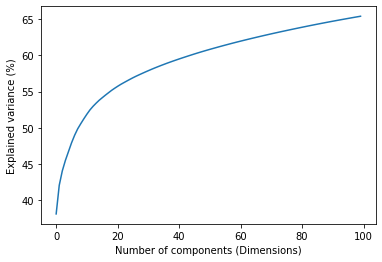

In [40]:
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.show()

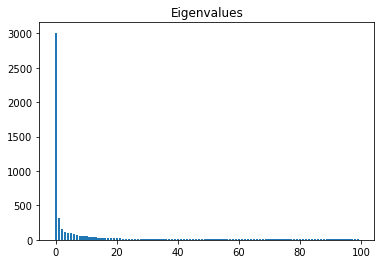

In [41]:
plt.bar(range(pca.n_components), pca.explained_variance_)
plt.title("Eigenvalues")
plt.show()

# Pipeline scores

In [42]:
scl = clf_pca.best_estimator_.named_steps['scaler']
model = clf_pca.best_estimator_.named_steps['clf']
X_scaled_train = scl.transform(X_train.values)
X_pca_train = pca.transform(X_scaled_train)
model.fit(X_pca_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000, penalty='l1',
                   random_state=42, solver='liblinear', tol=1e-06)

In [43]:
yhat_train = clf_pca.predict_proba(X_train)[:, 1]
thr_mcc, _, _ = print_thresholds(y_train, yhat_train)
yhat_valid = clf_pca.predict_proba(X_valid)[:, 1]
y_pred_thr_mcc_valid = np.array([1 if i >= thr_mcc else 0 for i in yhat_valid])
print_scores(y_valid, y_pred_thr_mcc_valid)
yhat_test = clf_pca.predict_proba(X_test)[:, 1]
y_pred_thr_mcc = np.array([1 if i >= thr_mcc else 0 for i in yhat_test])
print_scores(y_test, y_pred_thr_mcc)

Search for the best threshold by maximizing "matthews_corrcoef":
Threshold =	0.5693258807070398
Bal. Acc. =	0.9751213110817815
Accuracy =	0.9770787042451176
MCC score =	0.9453302897618892	

Search for the best threshold by maximizing "balanced_accuracy":
Threshold =	0.5693258807070398
Bal. Acc. =	0.9751213110817815
Accuracy =	0.9770787042451176
MCC score =	0.9453302897618892	

Bal. Acc. =	0.801
Accuracy =	0.848
MCC score =	0.632	

Bal. Acc. =	0.757
Accuracy =	0.818
MCC score =	0.558	



(0.8178294573643411, 0.5577541239337019)

In [ ]:
# saving results

In [ ]:
# import joblib
# joblib.dump(clf_pca, 'grid_search_CV_100.pkl')

In [45]:
# np.save('in_domain_dev.npy', X_h0_valid)
# np.save('out_of_domain_dev.npy', X_h0_test)
# np.save('in_domain_train.npy', X_h0_train)